## Basic Linear Regression


In this notebook, we work through code examples 4.37 onwards.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

az.style.use("arviz-darkgrid")


HOWELL1_DATA_LOCATION = '../../data/howell1.csv' 

In [2]:
df = pd.read_csv(HOWELL1_DATA_LOCATION)
df_adults = df[df['age'] >= 18]

In [3]:
df_adults.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.37

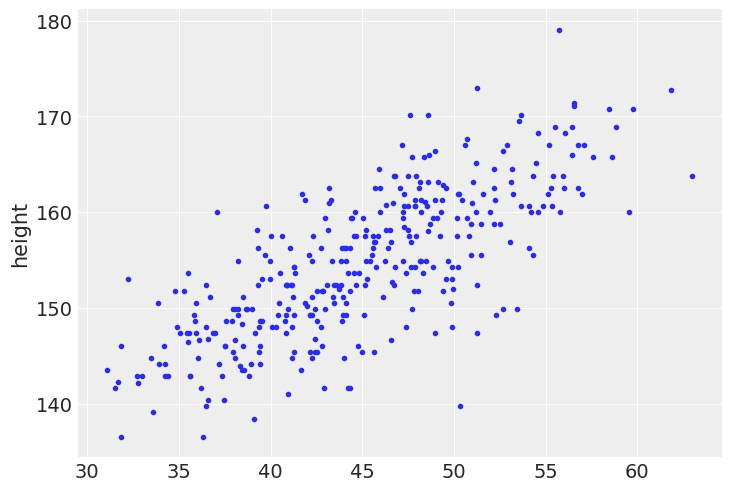

In [4]:
plt.plot(df_adults['weight'], df_adults['height'], '.')
plt.ylabel('height')

plt.show()

### The Model

The basic model that we dealt with in the last notebook was:
$$
\begin{align*}
    h_i & \overset{\text{iid}}{\sim} N(\mu, \sigma) \\
    \mu & \sim N(178, 20) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

We now postulate that the mean height $\mu$ depends linearly on the predictor variable `weight`, which is denoted by $x$. The modified model can be written as:
$$
\begin{align*}
    h_i    & \overset{\text{iid}}{\sim} N(\mu_i, \sigma) \\
    \mu_i  & = \alpha + \beta (x_i - \bar{x}) \\
    \alpha & \sim N(178, 20) \\
    \beta  & \sim N(0, 10) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

_From the book._

The mean $\mu$ is no longer a parameter to be estimated. Rather, as seen in the second line of the model, $\mu_i$ is constructed from other parameters, $\alpha$ and $\beta$, and the observed variable $x_i$. This line is not a stochastic relationship—there is no $\sim$ in it, but rather an $=$ in it—because the definition of $\mu_i$ is deterministic. That is to say that, once we know $\alpha$ and $\beta$ and $x_i$, we know $\mu_i$ with certainty.

### Prior Predictive Distribution

### Code 4.38 and 4.39

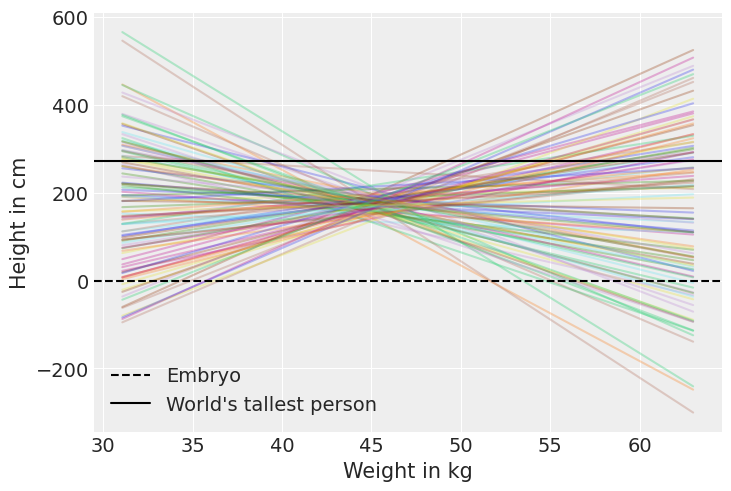

In [5]:
from scipy.stats import norm


N = 100 
a = norm.rvs(loc=178, scale=20, size=N)
b = norm.rvs(loc=0, scale=10, size=N)

x_bar = df_adults['weight'].mean()
x_min = df_adults['weight'].min()
x_max = df_adults['weight'].max()

wt_grid = np.linspace(x_min, x_max, 1000)

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for i in range(N):
    alpha_i = a[i]
    beta_i = b[i]
    
    mu_values = [alpha_i + beta_i * (x - x_bar) for x in wt_grid]
    
    plt.plot(wt_grid, mu_values, alpha=0.3)

plt.axhline(y=0, linestyle='--', color='black', label="Embryo")
plt.axhline(y=272, linestyle='-', color='black', label="World's tallest person")

plt.legend()

plt.show()

### $\beta$ as a Log-Normal Random Variable

Since we know that height is typically positively correlated with weight, we model $\beta$ as a log-normal variable instead of a normally distributed variable. A random variable $Y$ is log-normally distributed if the logarithm of $Y$ is normally distributed. Therefore let $Z = \log Y$ and assume that $Z \sim N(0, s)$, We wish to find out the distribution of $Y = e^{Z}$. Let $F_Y$ be the cdf of $Y$. 
$$
\begin{align*}
    F_Y(y) & = \text{Pr}\{ Y \leq y\} \\
           & = \text{Pr}\{ e^{Z} \leq y \} \\
           & = \text{Pr}\{ Z \leq \log y \} \\
           & = \int_{- \infty}^{\log y} \frac{1}{\sqrt{2 \pi} s} \cdot \exp \left \{ - \frac{x^2}{2s} \right \} dx
\end{align*}
$$

The pdf $f_Y$ of $Y$ is given by $\frac{d F_Y(y)}{dy}$. In order to evaluate the differential under the integral sign, we use Leibnitz's Theorem which states:
$$
    \frac{d}{dx} \int_{a(x)}^{b(x)} f(x, t) dt = f(x, b(x)) \frac{d b(x)}{dx} - f(x, a(x)) \frac{d a(x)}{d x} 
            + \int_{a(x)}^{b(x)} \frac{\partial f(x, t)}{\partial x} d t.
$$

to obtain:

$$
    f_Y(y) = \frac{1}{\sqrt{2 \pi}} \cdot \frac{1}{s y} \cdot \exp \left \{ - \frac{(\log y)^2}{2 s^2}\right \} \quad (0 < y < \infty).
$$

### Code 4.40

<AxesSubplot:ylabel='Density'>

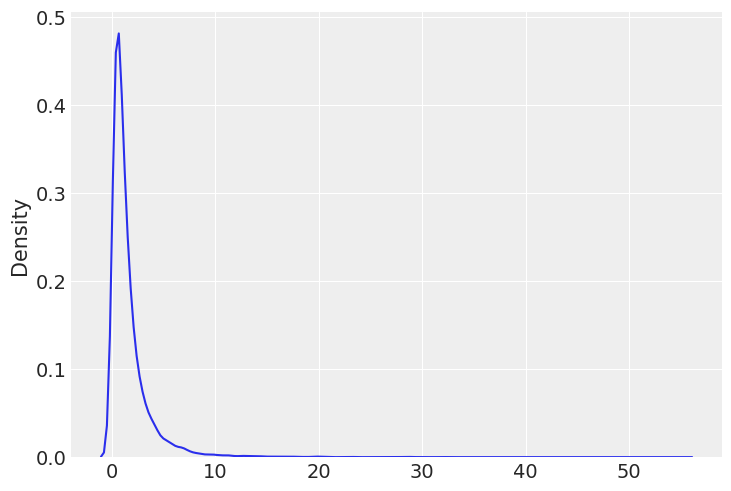

In [6]:
from scipy.stats import lognorm


beta_vals = lognorm.rvs(s=1, size=10000)
sns.kdeplot(beta_vals)

### Prior Predictive Simulation with Log-Normal Prior

### Code 4.41

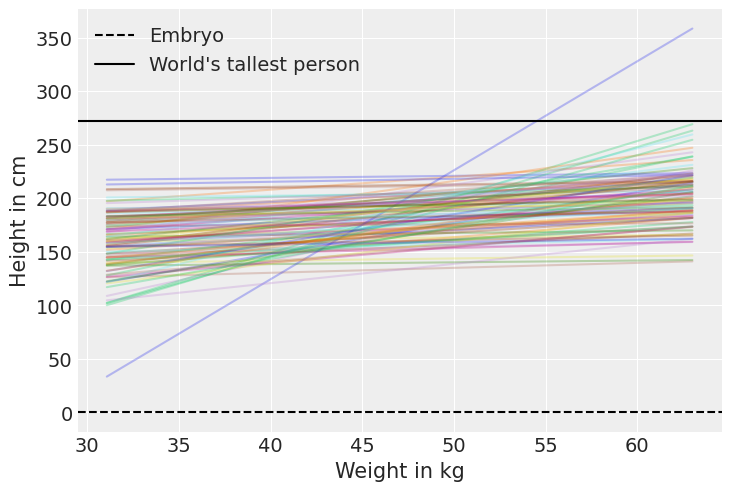

In [7]:
N = 100 
a = norm.rvs(loc=178, scale=20, size=N)
b = lognorm.rvs(s=1, size=N)

x_bar = df_adults['weight'].mean()
x_min = df_adults['weight'].min()
x_max = df_adults['weight'].max()

wt_grid = np.linspace(x_min, x_max, 1000)

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for i in range(N):
    alpha_i = a[i]
    beta_i = b[i]
    
    mu_values = [alpha_i + beta_i * (x - x_bar) for x in wt_grid]
    
    plt.plot(wt_grid, mu_values, alpha=0.3)

plt.axhline(y=0, linestyle='--', color='black', label="Embryo")
plt.axhline(y=272, linestyle='-', color='black', label="World's tallest person")

plt.legend()

plt.show()

### Finding the Posterior Distribution

$$
\begin{align*}
    h_i    & \overset{\text{iid}}{\sim} N(\mu_i, \sigma) \\
    \mu_i  & = \alpha + \beta (x_i - \bar{x}) \\
    \alpha & \sim N(178, 20) \\
    \beta  & \sim \text{Lognormal}(0, 1) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

### Code 4.42

In [8]:
with pm.Model() as m_4_3:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    x_bar = df_adults['weight'].mean()
    
    mu = alpha + beta * (df_adults['weight'] - x_bar)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df_adults['height'])
    
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

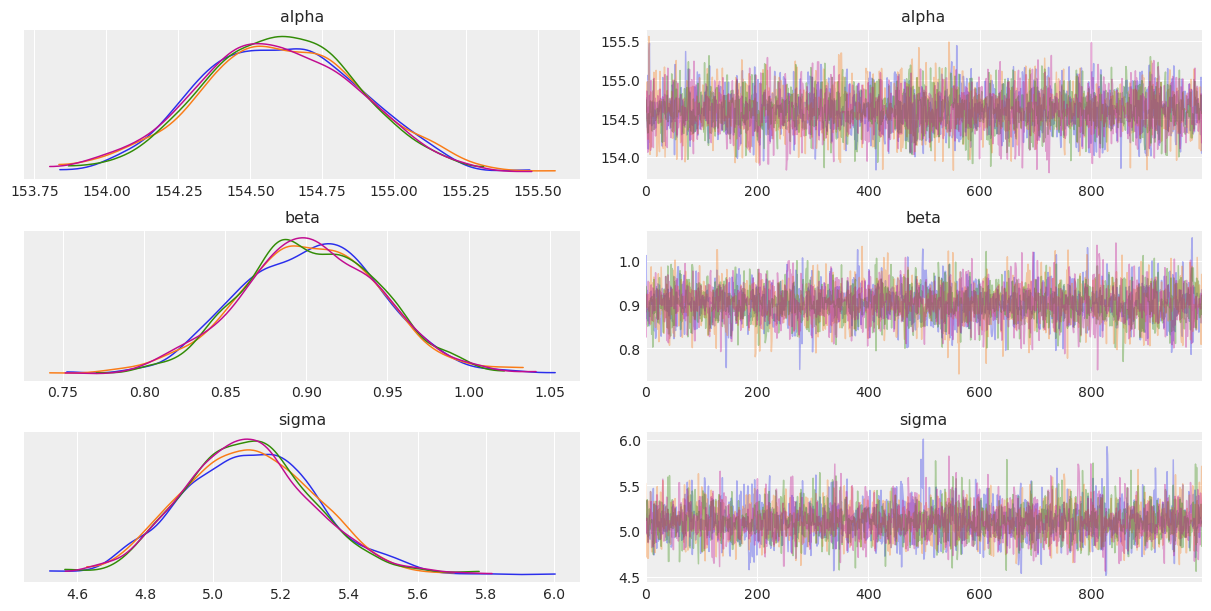

In [9]:
az.plot_trace(trace_4_3)

### Code 4.44

In [10]:
az.summary(trace_4_3, hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.601,0.273,154.182,155.051,0.004,0.003,5481.0,5481.0,5455.0,2949.0,1.0
beta,0.903,0.043,0.837,0.971,0.001,0.000,4975.0,4975.0,4984.0,2965.0,1.0
sigma,5.105,0.194,4.792,5.401,0.003,0.002,5495.0,5423.0,5605.0,3114.0,1.0


### Code 4.45

In [11]:
trace_df = pm.trace_to_dataframe(trace_4_3)

trace_df.cov().round(3)

,alpha,beta,sigma
alpha,0.075,-0.000,0.000
beta,-0.000,0.002,0.000
sigma,0.000,0.000,0.038


### Code 4.46

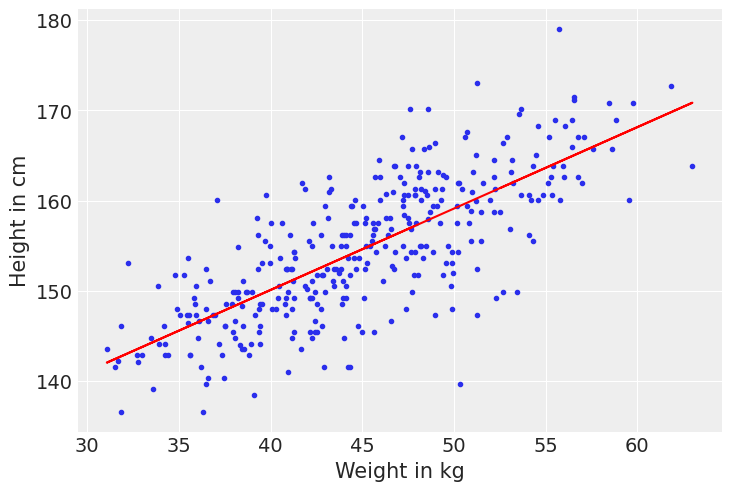

In [12]:
alpha_mean = trace_df['alpha'].mean()
beta_mean = trace_df['beta'].mean()
x_bar = df_adults['weight'].mean()

post_line = alpha_mean + beta_mean * (df_adults['weight'] - x_bar)

plt.plot(df_adults['weight'], df_adults['height'], '.')
plt.plot(df_adults['weight'], post_line, 'r-')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

plt.show()

### Modeling the Scattering Around the Mean Line 

In [13]:
trace_df.sample(2)

,alpha,beta,sigma
1589,154.434732,0.896974,5.007454
828,154.392003,0.862982,4.540495


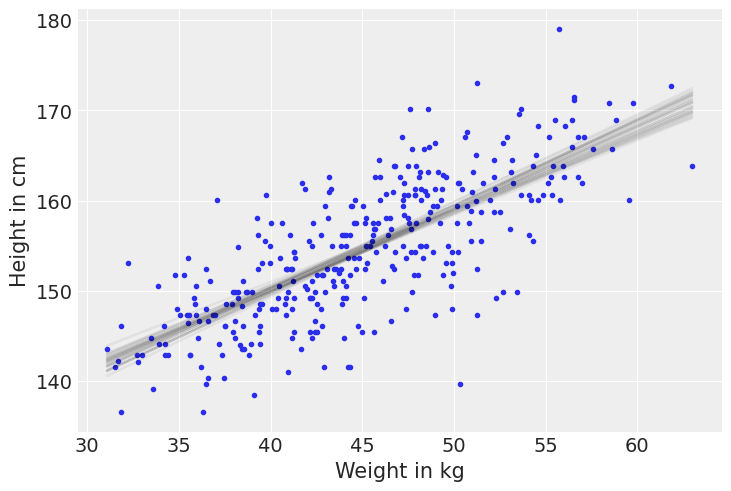

In [14]:
sample = trace_df.sample(30)
x_bar = df_adults['weight'].mean()

plt.plot(df_adults['weight'], df_adults['height'], '.')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for idx, row in sample.iterrows():
    post_line = row['alpha'] + row['beta'] * (df_adults['weight'] - x_bar)    
    plt.plot(df_adults['weight'], post_line, '-', color='black', alpha=0.05)

plt.show()

### Code 4.48

In [15]:
N = 100

with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    x_bar = df_adults['weight'][:N].mean()
    mu = alpha + beta * (df_adults['weight'][:N] - x_bar)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df_adults['height'][:N])
    
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

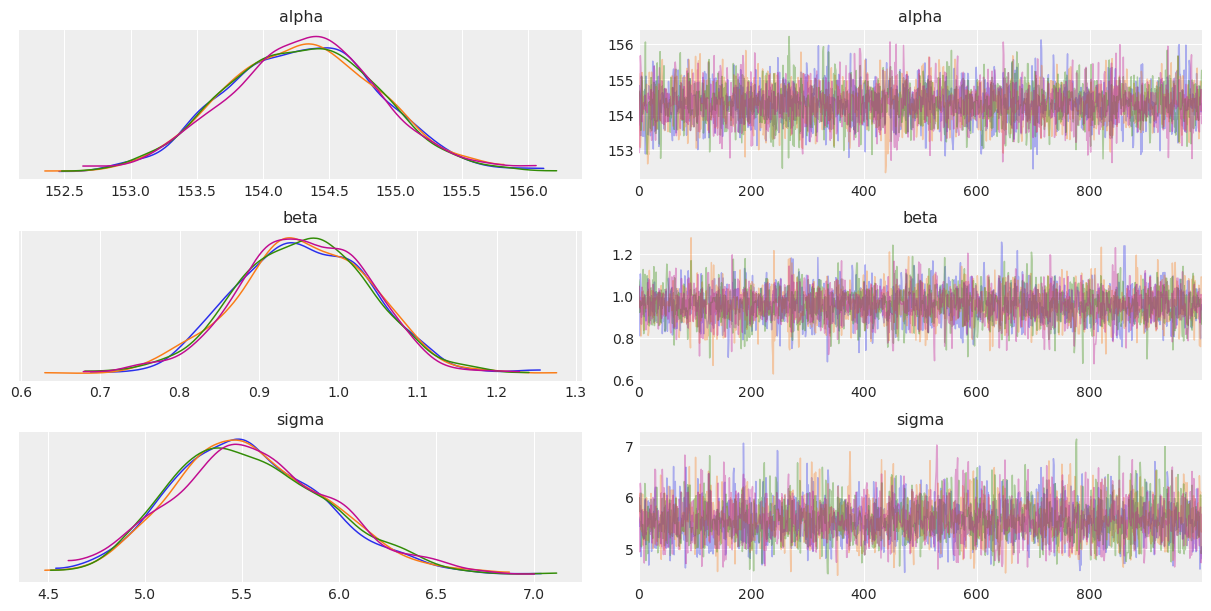

In [16]:
az.plot_trace(trace_N)

In [17]:
az.summary(trace_N, hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.299,0.574,153.395,155.195,0.008,0.006,5310.0,5310.0,5308.0,2855.0,1.0
beta,0.957,0.084,0.837,1.098,0.001,0.001,4908.0,4908.0,4950.0,2571.0,1.0
sigma,5.546,0.403,4.877,6.133,0.006,0.004,4429.0,4429.0,4368.0,2654.0,1.0


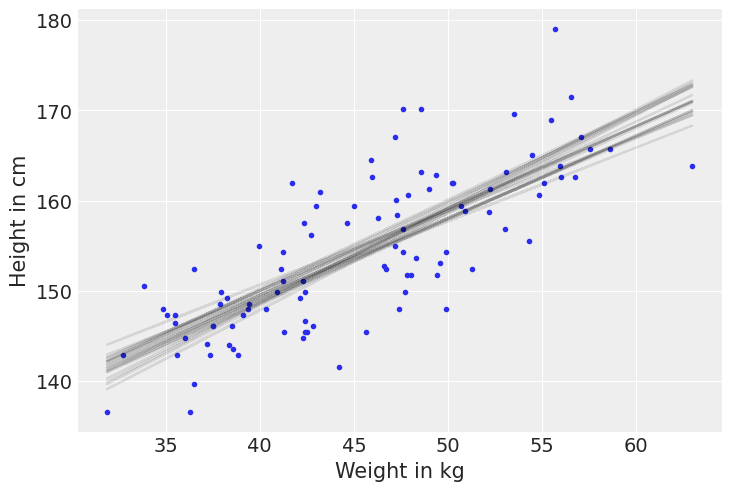

In [18]:
sample = pm.trace_to_dataframe(trace_N).sample(20)
x_bar = df_adults['weight'][:N].mean()

plt.plot(df_adults['weight'][:N], df_adults['height'][:N], '.')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for idx, row in sample.iterrows():
    post_line = row['alpha'] + row['beta'] * (df_adults['weight'][:N] - x_bar)    
    plt.plot(df_adults['weight'][:N], post_line, '-', color='black', alpha=0.1)

plt.show()

### Code 4.50 and 4.51

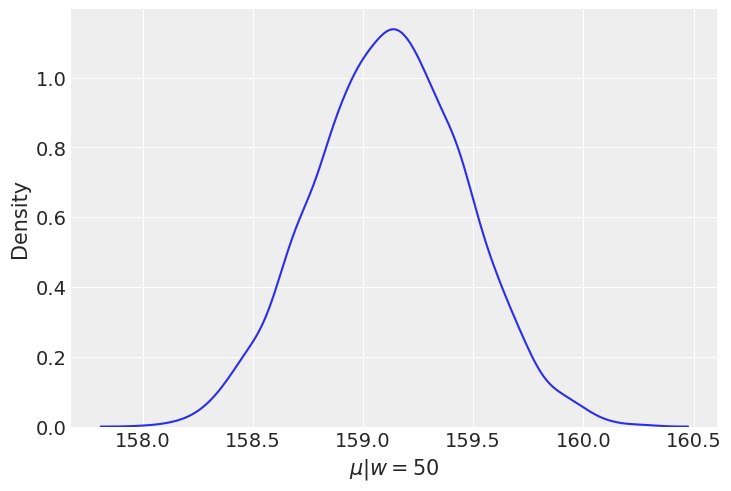

In [19]:
x_bar = df_adults['weight'].mean()

mu_at_50 = trace_df['alpha'] + trace_df['beta'] * (50 - x_bar)
sns.kdeplot(mu_at_50)

plt.xlabel(r'$\mu \vert w = 50$')

plt.show()

Note that the above distribution is not nearly normal. Had both $\alpha$ and $\beta$ been normally distributed, the variable $\alpha + \beta \cdot (50 - \bar{x})$ would have been normally distributed too. But we let $\beta \sim \text{Lognormal}(0, 1)$. 

### Code 4.52

In [20]:
az.hdi(mu_at_50.values, hdi_prob=0.89)

array([158.58822621, 159.67707417])

### Code 4.53 and 4.54

We define the PyMC3 model to include $\mu$ as a deterministic variable. Doing so, adds $\mu$ to the trace. If we do a `plot_trace` then the plots for all of the $\mu$ values would be plotted (recall that there are 352 of them). This might take some time. Which is why, we are not plotting the traces here. 

In the book, use is made of the `link` function. We do all of that manually. The model that we now create is named `m_link` for that reason.

In [21]:
with pm.Model() as m_link:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    x_bar = df_adults['weight'].mean()
    
    mu = pm.Deterministic('mu', alpha + beta * (df_adults['weight'] - x_bar))
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df_adults['height'])
    
    trace_link = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [22]:
df_trace_link = pm.trace_to_dataframe(trace_link)
df_trace_link.head()

,alpha,beta,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__342,mu__343,mu__344,mu__345,mu__346,mu__347,mu__348,mu__349,mu__350,mu__351
0,154.685704,0.929377,5.109123,157.320601,146.781649,142.487026,162.168519,151.234356,171.416450,148.415186,...,153.790052,157.373296,149.495429,151.023577,150.812798,156.582874,144.700206,161.351750,163.117025,161.694266
1,154.542623,0.913327,4.960375,157.132014,146.775073,142.554620,161.896207,151.150881,170.984422,148.380399,...,153.662439,157.183799,149.441985,150.943742,150.736603,156.407028,144.729577,161.093544,162.828331,161.430144
2,154.550217,0.921742,5.133785,157.163469,146.711094,142.451752,161.971561,151.127223,171.143519,148.331212,...,153.661923,157.215731,149.402581,150.918175,150.709128,156.431802,144.646750,161.161502,162.912274,161.501204
3,154.546448,0.870939,5.054447,157.015667,147.139388,143.114804,161.558756,151.312116,170.225191,148.670211,...,153.707114,157.065049,149.682530,151.114590,150.917065,156.324328,145.188822,160.793344,162.447621,161.114323
4,154.568395,0.887501,5.087412,157.084569,147.020480,142.919363,161.714050,151.272558,170.545289,148.580414,...,153.713099,157.134890,149.611983,151.071276,150.869994,156.380083,145.032822,160.934083,162.619818,161.261166


### Code 4.53

In [23]:
df_mu = df_trace_link.filter(regex=('mu.*'))
df_mu.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__342,mu__343,mu__344,mu__345,mu__346,mu__347,mu__348,mu__349,mu__350,mu__351
0,157.320601,146.781649,142.487026,162.168519,151.234356,171.416450,148.415186,164.434394,145.279848,163.512236,...,153.790052,157.373296,149.495429,151.023577,150.812798,156.582874,144.700206,161.351750,163.117025,161.694266
1,157.132014,146.775073,142.554620,161.896207,151.150881,170.984422,148.380399,164.122949,145.299209,163.216717,...,153.662439,157.183799,149.441985,150.943742,150.736603,156.407028,144.729577,161.093544,162.828331,161.430144
2,157.163469,146.711094,142.451752,161.971561,151.127223,171.143519,148.331212,164.218821,145.221631,163.304239,...,153.661923,157.215731,149.402581,150.918175,150.709128,156.431802,144.646750,161.161502,162.912274,161.501204
3,157.015667,147.139388,143.114804,161.558756,151.312116,170.225191,148.670211,163.682156,145.732018,162.817981,...,153.707114,157.065049,149.682530,151.114590,150.917065,156.324328,145.188822,160.793344,162.447621,161.114323
4,157.084569,147.020480,142.919363,161.714050,151.272558,170.545289,148.580414,163.877830,145.586347,162.997222,...,153.713099,157.134890,149.611983,151.071276,150.869994,156.380083,145.032822,160.934083,162.619818,161.261166


### Code 4.55

We are doing everything manually and plotting _all_ the data that we have. To do this, we first take the transpose of `df_mu`. This creates a matrix with one row per person. 

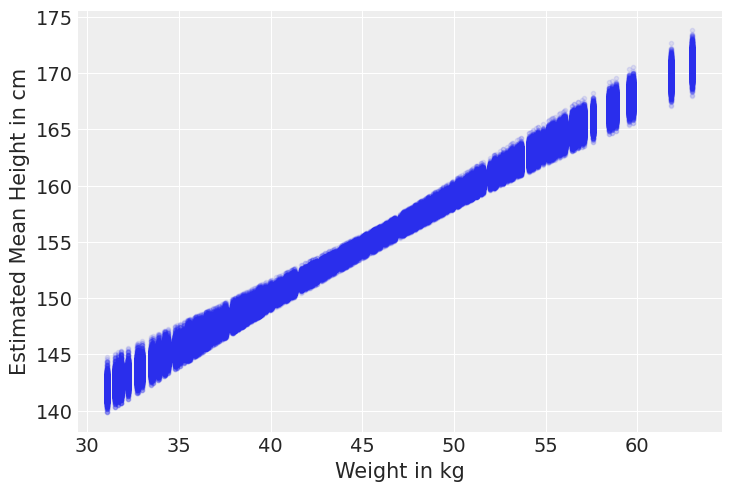

In [24]:
df_mu_T = df_mu.T

plt.xlabel('Weight in kg')
plt.ylabel(r'Estimated Mean Height in cm')

plt.plot(df_adults['weight'], df_mu_T.values, 'C0.', alpha=0.1)
plt.show()

### Code 4.56

`mu_mean` contains the average $\mu$ value for each weight. `mu_hdi` contains the $89\%$ probability intervals for the estimated value of $\mu$ for each weight value.

In [25]:
mu_mean = df_mu.apply(np.mean, axis=0)

# the np.expand_dims is used to supress a Future Warning from PyMC3
mu_hdi = az.hdi(np.expand_dims(df_mu.values, 0), hdi_prob=0.89)

In [26]:
mu_mean.head().reset_index()

,index,0
0,mu__0,157.165157
1,mu__1,146.927645
2,mu__2,142.755859
3,mu__3,161.874412
4,mu__4,151.252994


In [27]:
mu_hdi[:5]

array([[156.67194825, 157.63965953],
       [146.19025781, 147.66967476],
       [141.75535116, 143.78184154],
       [161.11160596, 162.55106306],
       [150.71844568, 151.7588151 ]])

In [28]:
mu_hdi.shape

(352, 2)

### Code 4.57

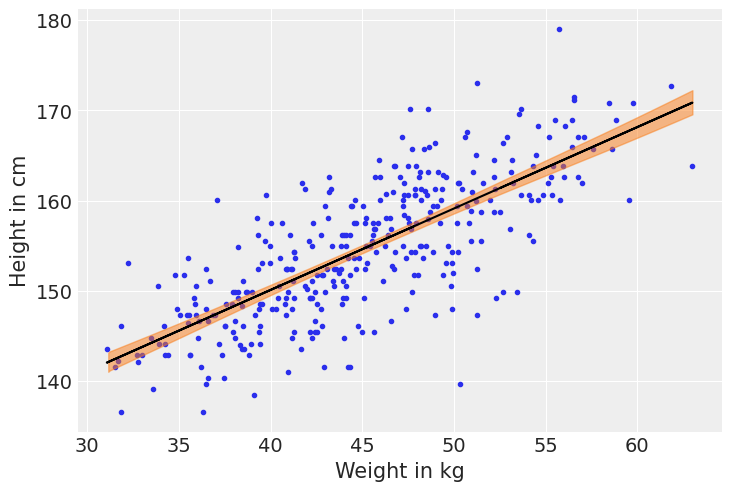

In [29]:
_, ax = plt.subplots()

wt = df_adults['weight']
ht = df_adults['height']

# Raw data
ax.scatter(wt, ht, marker='.')

# Estimated mean mu values against the weight 
ax.plot(wt, mu_mean, color='k')

# HPD intervals 
az.plot_hdi(wt, np.expand_dims(df_mu.values, 0), hdi_prob=0.89, ax=ax)

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

plt.show()

### Code 4.59

To generate posterior predictive samples from the model using PyMC3, we use the `pymc3.sampling.sample_posterior_predictive` method. This method returns a  `Dict[str, numpy.ndarray]`.

In [30]:
ht_sim = pm.sampling.sample_posterior_predictive(trace=trace_link, samples=5000, model=m_link)

In [31]:
ht_sim.keys()

dict_keys(['height'])

In [32]:
ht_sim['height'].shape

(5000, 352)

### Code 4.60

In [33]:
ht_hdi = az.hdi(np.expand_dims(ht_sim['height'], 0), hdi_prob=0.89)

In [34]:
ht_hdi.shape

(352, 2)

### Code 4.61

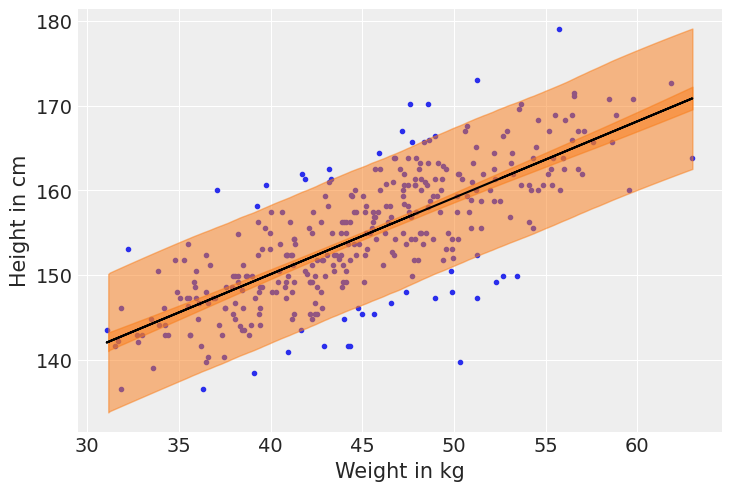

In [35]:
wt = df_adults['weight']
ht = df_adults['height']
ht_simulated = ht_sim['height']

_, ax = plt.subplots()

# Raw data
ax.scatter(wt, ht, marker='.')

# Mean mu values as function of weight
ax.plot(wt, mu_mean, color='k')

# Plot the hpd intervals for the height 
az.plot_hdi(wt, np.expand_dims(ht_simulated, 0), hdi_prob=0.89, ax=ax)

# Plot the hpd intervals for the mu values
az.plot_hdi(wt, np.expand_dims(df_mu.values, 0), hdi_prob=0.89, ax=ax)

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

plt.show()